In [ ]:
import cv2
from matplotlib import pyplot as plt
import math
import numpy as np
from copy import copy
from keras.datasets import mnist
from scipy.signal import convolve, convolve2d, correlate2d

assistance functions to handle the correlation task

In [ ]:
# calculating the dimensions of the output matrix using the formula -
# (Input height + padding height top + padding height bottom - kernel height) / (stride height) + 1 
def calculate_single_dim_conv_output(h_in, padding, kernel_size, stride):
    return ((h_in - kernel_size + 2 * padding) / stride) + 1

def calculate_conv_output_hw(h_in, w_in, padding, kernel_size, stride):
    return math.ceil(calculate_single_dim_conv_output(h_in, padding, kernel_size[0], stride)), \
           math.ceil(calculate_single_dim_conv_output(w_in, padding, kernel_size[1], stride))

# calculating the padding size using the formula -
# dim_out = (Input height + padding height top + padding height bottom - kernel height) / (stride height) + 1 
def calculate_padding_single_dim(dim_in, dim_out, kernel_size, stride=1):
    return math.ceil((stride*dim_out - stride - dim_in + kernel_size)/2)

# relue function
def relu(output):
    return np.where(output > 0, output,0)

class that handles with the correlation task

In [ ]:
# class i created to handle correlation and convolution tasks
class MyConv2D:

    def __init__(self, img, kernel, pad, N, stride=1, NORM=False, flip=True, ACTV=None):
        
        # setting all parameters
        self.img = copy(img)
        self.layers = N
        self.NORM = NORM
        self.ACTV = ACTV
        self.kernel = kernel
        self.set_kernel(kernel, flip)
        self.stride = stride
        self.set_padding(pad)
        self.pad = pad
        self.ndim = img.ndim

    # get height of input
    def get_h_in(self):
        return int(self.img.shape[0])
    
    # get width of input
    def get_w_in(self):
        return int(self.img.shape[1])

    # get kernel size
    def get_kernel_size(self):
      if len(self.kernel.shape)==3:
        return self.kernel.shape[1], self.kernel.shape[2]
      else:
        return self.kernel.shape

    # get num of channels
    def get_channels_in(self):
        if self.ndim == 3:
            return self.img.shape[2]
        else:
            return 1
    
    #set padding 
    def set_padding(self, pad):
        if isinstance(pad, int):
            self.padding = pad
        if isinstance(pad, str):
            self.padding = self.calculate_padding(self.get_h_in(), self.get_w_in(), self.get_kernel_size(),
                                                  self.stride, padding=pad)
    # set kernel
    def set_kernel(self, kernel, flip):
        
        if flip:# for convolution
            self.kernel = np.flip(kernel)
        else:# for correlation
            self.kernel = kernel

    # calculate padding for same, full and valid
    @staticmethod
    def calculate_padding(h_in, w_in, kernel_size, stride=1, padding='same'):
        if padding.lower() == 'same':
            return calculate_padding_single_dim(h_in, h_in, kernel_size[0], stride)

        if padding.lower() == 'full':
            return kernel_size[0] - 1
        else:  
            return 0
    
    #single channel correlation/convolution operation 
    def my_conv_single_channel(self, img, filter, single_channel_image=None):
        
        # Retrieve dimensions img's shape
        (n_H_prev, n_W_prev) = img.shape
        
        # Retrieve dimensions from filter's shape
        (f1, f2) = filter.shape

        # Compute the dimensions of the CONV output volume
        n_H, n_W = calculate_conv_output_hw(n_H_prev, n_W_prev, self.padding, (f1, f2), self.stride)

        # Initialize the output volume Z with zeros.
        Z = np.zeros([n_H, n_W])

        # zero padding
        a_prev_pad =  np.pad(img, self.padding, mode='constant')

        for h in range(n_H):  # loop over vertical axis of the output volume
            for w in range(n_W):  # loop over horizontal axis of the output volume

                # Find the corners of the current "slice"
                vert_start = h * self.stride
                vert_end = h * self.stride + f1
                horiz_start = w * self.stride
                horiz_end = w * self.stride + f2

                # allows us to check if we are at the end of the image in the y or x direction.
                if a_prev_pad.shape[0] < vert_end or a_prev_pad.shape[1] < horiz_end:
                  continue

                # Use the corners to define the slice of a_prev_pad
                a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end]

                # if batch normalization is set
                if self.NORM:
                  epsilon = 0.00001
                  s1 = np.sum(np.multiply(a_slice_prev - np.mean(a_slice_prev), filter - np.mean(filter)))
                  s2 = math.sqrt(np.sum(np.multiply((a_slice_prev - np.mean(a_slice_prev))**2, (filter - np.mean(filter))**2))) + epsilon
                  s = s1 / s2
                else: #no normalization
                  # Element-wise product between a_slice and filter and Sum over all entries.
                  s = np.sum(np.multiply(a_slice_prev, filter))
                
                # s -- a scalar value, result of convolving the sliding window on a slice of the input data
                Z[h, w] = s
        return Z
    
    #multi channel correlation/convolution operation  
    def my_conv_multi_channel(self, filter):
        
        # Retrieve dimensions img's shape      
        (n_H, n_W, c) = self.img.shape
        
        # Compute the dimensions of the CONV output volume
        n_H, n_W = calculate_conv_output_hw(n_H, n_W, self.padding, self.get_kernel_size(), self.stride)

        # Initialize the output volume Z with zeros.
        Z = np.zeros([n_H, n_W])

        # runnig through all the channels
        for i in range(c):
          Z[:, :] += self.my_conv_single_channel(self.img[:,:,i], filter)
        
        return Z
    
    # operate filter with convolution/correlation on input
    def operate_filter(self):
      
      #in case of multi channel input 
      if len(self.img.shape) == 3:
        (n_H, n_W, c) = self.img.shape
      else:
        (n_H, n_W) = self.img.shape

      # Compute the dimensions of the CONV output volume
      n_H, n_W = calculate_conv_output_hw(n_H, n_W, self.padding, self.get_kernel_size(), self.stride)

      # in case of multi channel filter
      if len(self.kernel.shape) == 3:
        (c, _, __) = self.kernel.shape

        # Initialize the output volume Z with zeros.
        Z = np.zeros([n_H, n_W, c])

        # runnig through all the filter channels
        for i in range(c):

          if len(self.img.shape) == 3:#if input is multi channel
            Z[:, :, i] = self.my_conv_multi_channel(self.kernel[i, :, :])
          else:#if input is singal channel
            Z[:, :, i] = self.my_conv_single_channel(self.img, self.kernel[i, :, :])
        
        return Z
      else:#in case of singal channel filter

        # Initialize the output volume Z with zeros.
        Z = np.zeros([n_H, n_W, 1])

        if len(self.img.shape) == 3:#if input is multi channel
          Z[:, :, 0] = self.my_conv_multi_channel(self.kernel)
        else:#if input is singal channel
          Z[:, :, 0] = self.my_conv_single_channel(self.img, self.kernel)
        
        return Z
    
    # running the convolution/correlation net, through all the layers (N)
    def net(self):
        for i in range(self.layers):

          # running convolution/correlation on input
          self.img = self.operate_filter()
          
          #update input parameters 
          self.ndim = self.img.ndim
          self.set_padding(self.pad)

          # applying activation function if set
          if self.ACTV:
            self.img = self.ACTV(self.img)

        return self.img

myCorr function

In [ ]:
# myCorr function to aplly correlation/convolution
def myCorr(Im, Ker, S, P, N, Norm=False, CORR=False, ACTV=False):
  # create an object of the class icreated to handle correlation/convolution
  my_conv2d = MyConv2D(Im, Ker, P, N, stride=S, ACTV=ACTV, flip= not CORR, NORM=Norm)
  return my_conv2d.net()

mse for verification

In [ ]:
def mse(r_img, gt_img):
    r_img = r_img.astype(np.float)
    gt_img = gt_img.astype(np.float)
    return np.sum((gt_img*gt_img - 2*r_img*gt_img + r_img*r_img))/r_img.size

Verification function that measures the MSE between myCorr implementation output and the one from scipy, expecting for low result

In [ ]:
# measure the MSE between myConv2d implementation and the one from scipy, expecting for low results
def Verification_function(img):
  # sobel x filter
  sobelx_filter = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
  # sobel y filter
  sobely_filter = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
  # sharpen filter
  sharpen_filter = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])*0.25

  # scipy convolution
  sobelx_scipy = convolve2d(img, sobelx_filter, mode='same')
  sobely_scipy = convolve2d(img, sobely_filter, mode='same')
  sharpen_scipy = convolve2d(img, sharpen_filter, mode='same')
  
  # my convolution implementation 
  sobelx_myConv = myCorr (img, sobelx_filter, 1, 'same', 1, Norm=False, CORR=False , ACTV=False) [:,:,0]
  sobely_myConv = myCorr (img, sobely_filter, 1, 'same', 1, Norm=False, CORR=False , ACTV=False)[:,:,0]
  sharpen_myConv = myCorr (img, sharpen_filter, 1, 'same', 1, Norm=False, CORR=False , ACTV=False)[:,:,0]

  # MSE results
  print("sobelx convolution mse - ",mse(sobelx_scipy,sobelx_myConv))
  print("sobely convolution mse - ",mse(sobely_scipy,sobely_myConv))
  print("sharpen convolution mse - ",mse(sharpen_scipy,sharpen_myConv))

In [ ]:
# verifiy waldo image
waldo = cv2.imread('/content/waldo.jpg')
waldo = cv2.cvtColor(waldo, cv2.COLOR_BGR2GRAY)
Verification_function(waldo)

sobelx convolution mse -  0.0
sobely convolution mse -  0.0
sharpen convolution mse -  0.0


In [ ]:
# verifiy mnist image
(x_train, y_train), (x_test, y_test) = mnist.load_data()
mnist_img = x_train[10]
Verification_function(mnist_img)

11493376/11490434 [==============================] - 0s 0us/step
sobelx convolution mse -  0.0
sobely convolution mse -  0.0
sharpen convolution mse -  0.0


demonstrating mult-channel filters operated on a single image and N layers (for kernal of FxFxN shape and FxFx1 shape)

In [ ]:
# set the input image
img = np.array([[200,200,200,200,200,200,200,40],
                [40,200,200,200,200,200,40,40],
                [40,40,200,200,200,40,40,40],
                [40,40,40,200,40,40,40,40],
                [40,40,40,40,40,40,40,40],
                [160,160,160,160,160,160,160,160],
                [160,160,160,160,160,160,160,160],
                [160,160,160,160,160,160,160,160]])

# set kernel of FxFx1 shape
kernel_1 = np.array([[1, 2, 0],[2, 0, -2], [0, -2, -1]])*0.2

# set kernel of FxFx3
kernel_N = np.array([kernel_1, kernel_1, kernel_1])

# set layers of the net to 1
layers_1 = 1

# set layers of the net to 1
layers_2 = 2

# set activation
actv_relu = relu

# no activation
actv_none = None

# kernel of FxFx1 shape, 1 layer net, no activation, stride 1
result1 = myCorr(img, kernel_1, 1, 'valid', layers_1, Norm=False, CORR=False , ACTV=actv_none)

# kernel of FxFx3 shape, 2 layer net, relu activation, stride 2
result2 = myCorr(img, kernel_N, 2, 2, layers_2, Norm=False, CORR=False , ACTV=actv_relu)

# expected shape of the first output is W1xH1x1 lets print and check it
print('result 1 shape - ', result1.shape)

# expected shape of the first output is W1xH1x3 lets print and check it
print('result 2 shape - ',result2.shape)

# results1 convolution output
print('result 1 output -\n',result1[:, :, 0])


result 1 shape -  (6, 6, 1)
result 2 shape -  (5, 5, 3)
result 1 output -
 [[   0.    0.    0.  -32. -160. -160.]
 [   0.    0.  -32. -160. -160.  -32.]
 [   0.    0.  -96. -160.  -32.    0.]
 [  72.   72.    8.   40.   72.   72.]
 [  72.   72.   72.   72.   72.   72.]
 [   0.    0.    0.    0.    0.    0.]]


demonstrate diffrent hyperparmeters

In [ ]:
def demonstrate_filters_and_hyperParameters(img, filter, filter_title, img_name):
  
  #set dictionarys of hyper parameters to be preform 
  strides = {",stride - 1" : 1, ",stride - 2" : 2}
  paddings = {",padding is valid" : "valid", ",padding is same" : "same", ",padding is 2" : 2}
  layers = {",N = 1" : 1, ",N = 3" : 3}
  Normalize = {", with batch normalization" : True, ",no normalization" : False}
  correlation = {"correlation" : True, "convolution" : False}
  activation = {"with relu activation" : relu, "without activation" : None}
  # cv2.imwrite(name,image[:,:,0])
  plt.figure(figsize=(1, 130), dpi=700)
  count = 1
  for stride, stride_title in zip(strides.values(), strides.keys()):
    for padding, padding_title in zip(paddings.values(), paddings.keys()):
      for layer, layer_title in zip(layers.values(), layers.keys()):
        for norm, norm_title in zip(Normalize.values(), Normalize.keys()):
          for corr, corr_title in zip(correlation.values(), correlation.keys()):
            for actv, actv_title in zip(activation.values(), activation.keys()):
              image = myCorr (img, filter, stride, padding, layer, Norm=norm, CORR=corr , ACTV=actv)
              plt.subplot(100, 1, count)
              plt.title(corr_title + " " + filter_title + " " + stride_title + " " + padding_title + " " + layer_title + " " + norm_title + " " + actv_title)
              plt.imshow(image[:,:,0],"gray")
              name = '/content/' +img_name + "_" + corr_title + "_" + filter_title + "_" + stride_title + "_" + padding_title + "_" + layer_title + "_" + norm_title + "_" + actv_title+'.jpg'
              # cv2.imwrite(name,image[:,:,0])
              count += 1

demonstrate the use of 10 filters

In [ ]:
# demonstrate filters
def demonstrate_filters(img):
  # blur filter
  LPF_filter = np.ones((7, 7))*(1/49)
  # laplacian filter
  laplacian_filter = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])
  # sobel x filter
  sobelx_filter = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
  # sobel y filter
  sobely_filter = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
  # sharpen filter
  sharpen_filter = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])*0.25
  # shifted right filter
  shiftedRight_filter = np.array([[0,0,0],[0,0,1],[0,0,0]])
  # HPF filter
  HPF_filter = np.array([[-1,-1,-1],[1,8,-1],[-1,-1,-1]])
  # outLine filter
  filter3 = np.array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
                    ,[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
                    ,[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
                    ,[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
                    ,[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])
  # emboss filter
  emboss_filter = np.array([[-2,-1,0],[-1,1,1],[0,1,2]])
  # reduce channel filter
  reduceChannel_filter = np.array([[1]])
  
  #set dictionarys of filters and hyper parameters to be preform 
  filters = {"blur filter" : LPF_filter, "laplacian" : laplacian_filter, "sobel x" : sobelx_filter, "sobel y" : sobely_filter,\
             "sharpen" : sharpen_filter, "shifted right" : shiftedRight_filter, "HPF" : HPF_filter, "filter3" : filter3,\
             "emboss" : emboss_filter, "reduced to single channel" : reduceChannel_filter}
  count = 1
  plt.figure(figsize=(7, 20), dpi=100)
  for filter, filter_title in zip(filters.values(), filters.keys()):
    image = myCorr (img, filter, 1, "same", 1, Norm=False, CORR=False , ACTV=None)
    plt.subplot(5, 2, count)
    plt.title(filter_title)
    plt.imshow(image[:,:,0], 'gray')
    count += 1

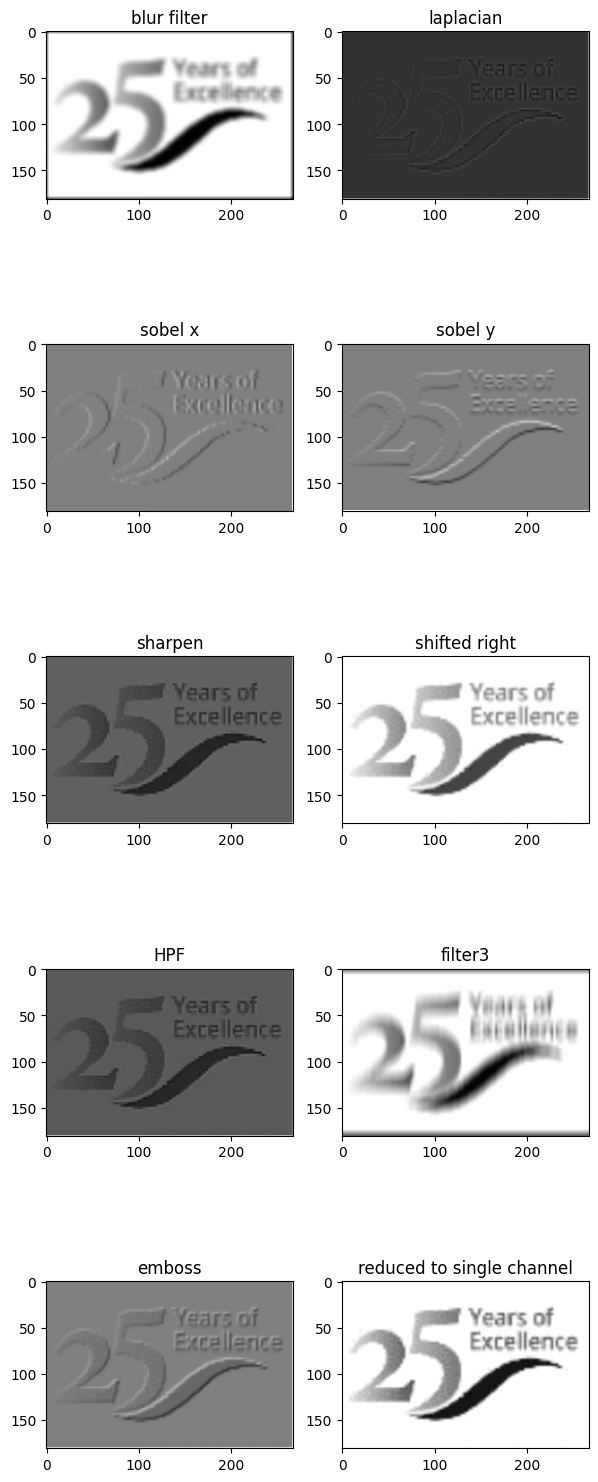

In [ ]:
afeka = cv2.imread('/content/afeka.jpg')
afeka = cv2.cvtColor(afeka, cv2.COLOR_BGR2GRAY)
demonstrate_filters(afeka)

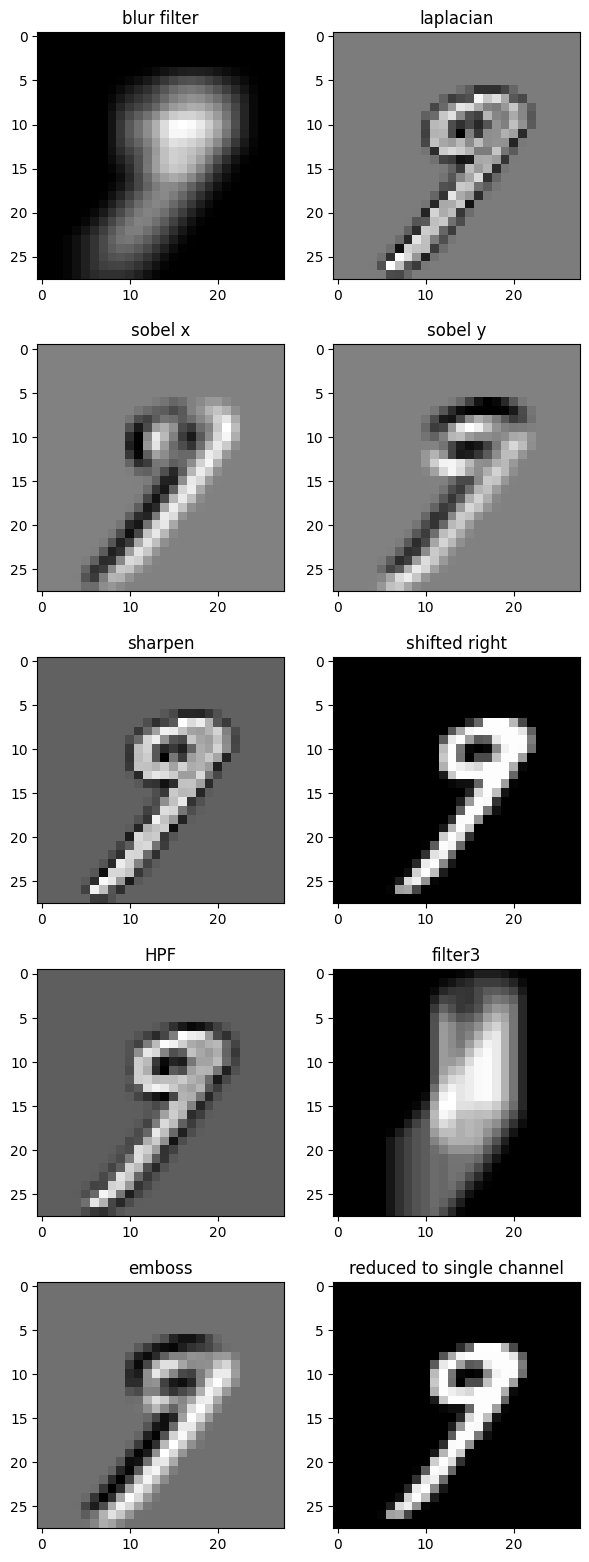

In [ ]:
mnist_img = x_train[33]
demonstrate_filters(mnist_img)

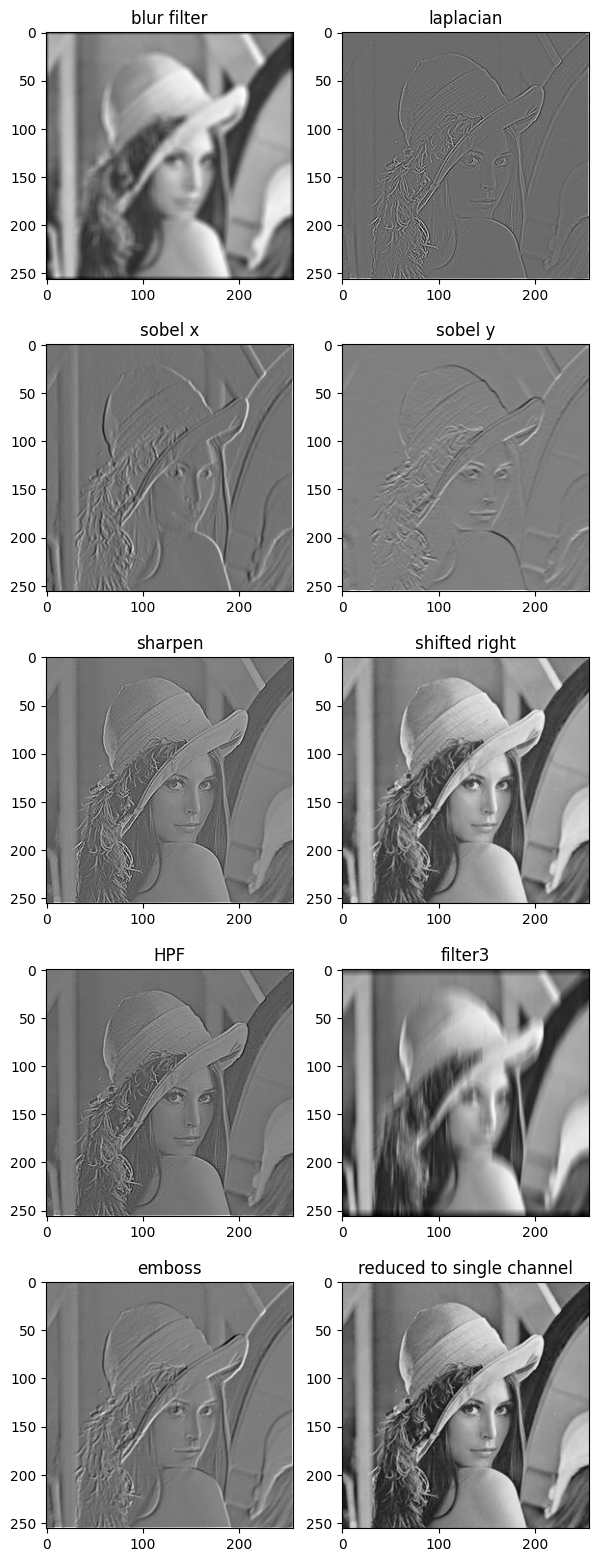

In [ ]:
# lena RGB convolution
lena = cv2.imread('/content/lena_color.jpg')
lena = cv2.cvtColor(lena, cv2.COLOR_BGR2RGB)
demonstrate_filters(lena)

demonstrate the template matching ability

In [ ]:
def template_matching(img, template, dpi=500, t_h=False):
  image = myCorr(img, template, 1, 'same', 1, Norm=True, CORR=True , ACTV=False)
  plt.figure(figsize=(40, 10), dpi=dpi)
  if not t_h:
    trash_hold = image[:,:,0]
  else:
    trash_hold = np.where(image[:,:,0] >= np.max(image[:,:,0]) - 3, 255,0)
  plt.subplot(1, 3, 1)
  if len(img.shape) == 3:
      plt.title("original image")
      plt.imshow(img)
      plt.subplot(1, 3, 2)
      plt.title("template")
      plt.imshow(template)
  else:
    plt.title("original image")
    plt.imshow(img, 'gray')
    plt.subplot(1, 3, 2)
    plt.title("template")
    plt.imshow(template, 'gray')
  plt.subplot(1, 3, 3)
  plt.title("template matching")
  plt.imshow(trash_hold, 'gray')

In [ ]:
shape = cv2.imread('/content/shapes.jpg')
shape = cv2.cvtColor(shape, cv2.COLOR_BGR2GRAY)
shape_template = cv2.imread('/content/shapes_template.jpg')
shape_template = cv2.cvtColor(shape_template, cv2.COLOR_BGR2GRAY)
template_matching(shape, shape_template)

In [ ]:
waldo = cv2.imread('/content/waldo.jpg')
waldo = cv2.cvtColor(waldo, cv2.COLOR_BGR2GRAY)
waldo_template = cv2.imread('/content/waldo_template.jpg')
waldo_template = cv2.cvtColor(waldo_template, cv2.COLOR_BGR2GRAY)
template_matching(waldo, waldo_template)

In [ ]:
messi = cv2.imread('/content/messi_image.jpg')
messi = cv2.cvtColor(messi, cv2.COLOR_BGR2GRAY)
messi_template = cv2.imread('/content/messi_image_template.jpg')
messi_template = cv2.cvtColor(messi_template, cv2.COLOR_BGR2GRAY)
template_matching(messi, messi_template)

create gaussian kernel function

In [ ]:
def gkern(l=5, sig=1.):
    """\
    creates gaussian kernel with side length l and a sigma of sig
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))
    return kernel / np.sum(kernel)

explanation for exercise 2 

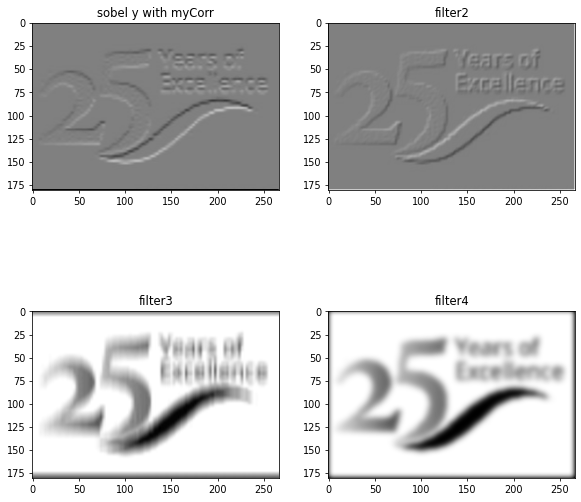

In [ ]:
afeka_logo = cv2.imread('/content/afeka.jpg')
afeka_logo = cv2.cvtColor(afeka_logo, cv2.COLOR_BGR2GRAY)
kernel1 = np.array([[1, 2, 1],[0, 0, 0], [-1, -2, -1]])
kernel2 = np.array([[-1, -2, 0],[-2, 0, 2], [0, 2, 1]])
kernel3 = np.array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
                    ,[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
                    ,[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
                    ,[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
                    ,[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])
kernel4 = gkern(l=15, sig=3)
img1 = myCorr(afeka_logo, kernel1, 1, 'same', 1)[:, :, 0]
img2 = myCorr(afeka_logo, kernel2, 1, 'same', 1)[:, :, 0]
img3 = myCorr(afeka_logo, kernel3, 1, 'same', 1)[:, :, 0]
img4 = myCorr(afeka_logo, kernel4, 1, 'same', 1)[:, :, 0]
plt.figure(figsize=(10, 10), dpi=70)
plt.subplot(2, 2, 1)
plt.title('sobel y with myCorr')
plt.imshow(img1,'gray')
plt.subplot(2, 2, 2)
plt.title('filter2')
plt.imshow(img2,'gray')
plt.subplot(2, 2, 3)
plt.title('filter3')
plt.imshow(img3,'gray')
plt.subplot(2, 2, 4)
plt.title('filter4')
plt.imshow(img4,'gray')